In [23]:
import time

import numpy
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sp_spec
import scipy.stats as sp_stats

## Assignment 2A. Problem 2.2.8 SVI.

### Generate data
The cell below generates data for the LDA model. Note, for simplicity, we are using N_d = N for all d.

In [ ]:
import torch
import torch.distributions as t_dist

def generate_data(D, N, K, W, eta, alpha):
    """
    Torch implementation for generating data using the LDA model. Faster for larger datasets.
    D = number of documents
    N = number of words in each document
    K = number of topics
    W = number of words in vocabulary
    """
    # sample K topics
    beta_dist = t_dist.Dirichlet(torch.from_numpy(eta))
    beta = beta_dist.sample([K])  # size K x W

    # sample document topic distribution
    theta_dist = t_dist.Dirichlet(torch.from_numpy(alpha))
    theta = theta_dist.sample([D]) # size D x K

    # sample word to topic assignment
    z_dist = t_dist.OneHotCategorical(probs=theta)
    z = z_dist.sample([N])
    z = torch.einsum("ndk->dnk", z)

    # sample word from selected topics
    beta_select = torch.einsum("kw, dnk -> dnw", beta, z)
    w_dist = t_dist.OneHotCategorical(probs=beta_select)
    w = w_dist.sample([1])

    w = w.reshape(D, N, W)

    return w.numpy(), z.numpy(), theta.numpy(), beta.numpy()

torch.manual_seed(1)

D_sim = 500
N_sim = 1000
K_sim = 2
W_sim = 10

eta_sim = np.ones(W_sim)
eta_sim[3] = 0.0001     # Expect word 3 to not appear in data
eta_sim[1] = 3.         # Expect word 1 to be most common in data
alpha_sim = np.ones(K_sim) * 1.0
w0, z0, theta0, beta0 = generate_data(D_sim, N_sim, K_sim, W_sim, eta_sim, alpha_sim)
w_cat = w0.argmax(axis=-1)  # remove one hot encoding
unique_z, counts_z = numpy.unique(z0[0, :], return_counts=True)
unique_w, counts_w = numpy.unique(w_cat[0, :], return_counts=True)

# Sanity checks for data generation
print(f"Average z of each document should be close to theta of document. \n Theta of doc 0: {theta0[0]}"
      f" \n Mean z of doc 0: {z0[0].mean(axis=0)}")
print(f"Beta of topic 0: {beta0[0]}")
print(f"Beta of topic 1: {beta0[1]}")
print(f"Word to topic assignment, z, of document 0: {z0[0, 0:10]}")
print(f"Observed words, w, of document 0: {w_cat[0, 0:10]}")
print(f"Unique words and count of document 0: {[f'{u}: {c}' for u, c in zip(unique_w, counts_w)]}")

Average z of each document should be close to theta of document. 
 Theta of doc 0: [0.140 0.860] 
 Mean z of doc 0: [0.134 0.866]
Beta of topic 0: [0.135 0.309 0.036 0.000 0.009 0.068 0.043 0.092 0.103 0.206]
Beta of topic 1: [0.351 0.217 0.081 0.000 0.014 0.099 0.105 0.046 0.016 0.072]
Word to topic assignment, z, of document 0: [[0.000 1.000]
 [0.000 1.000]
 [0.000 1.000]
 [0.000 1.000]
 [0.000 1.000]
 [0.000 1.000]
 [1.000 0.000]
 [0.000 1.000]
 [1.000 0.000]
 [0.000 1.000]]
Observed words, w, of document 0: [1 9 1 0 1 6 7 1 8 0]
Unique words and count of document 0: ['0: 330', '1: 257', '2: 61', '4: 9', '5: 87', '6: 94', '7: 52', '8: 31', '9: 79']


### Helper functions

In [159]:
def log_multivariate_beta_function(a, axis=None):
    return np.sum(sp_spec.gammaln(a)) - sp_spec.gammaln(np.sum(a, axis=axis))

### CAVI Implementation, ELBO and initialization

In [160]:
def initialize_q(w, D, N, K, W):
    """
    Random initialization.
    """
    phi_init = np.random.random(size=(D, N, K))
    phi_init = phi_init / np.sum(phi_init, axis=-1, keepdims=True)
    gamma_init = np.random.randint(1, 10, size=(D, K))
    lmbda_init = np.random.randint(1, 10, size=(K, W))
    return phi_init, gamma_init, lmbda_init

def update_q_Z(w, gamma, lmbda):
    D, N, W = w.shape
    K, W = lmbda.shape
    E_log_theta = sp_spec.digamma(gamma) - sp_spec.digamma(np.sum(gamma, axis=1, keepdims=True))  # size D x K
    E_log_beta = sp_spec.digamma(lmbda) - sp_spec.digamma(np.sum(lmbda, axis=1, keepdims=True))   # size K x W
    log_rho = np.zeros((D, N, K))
    w_label = w.argmax(axis=-1)
    for d in range(D):
        for n in range(N):
            E_log_beta_wdn = E_log_beta[:, int(w_label[d, n])]
            E_log_theta_d = E_log_theta[d]
            log_rho_n = E_log_theta_d + E_log_beta_wdn
            log_rho[d, n, :] = log_rho_n

    phi = np.exp(log_rho - sp_spec.logsumexp(log_rho, axis=-1, keepdims=True))
    return phi

def update_q_theta(phi, alpha):
    E_Z = phi
    D, N, K = phi.shape
    gamma = np.zeros((D, K))
    for d in range(D):
        E_Z_d = E_Z[d]
        gamma[d] = alpha + np.sum(E_Z_d, axis=0)  # sum over N
    return gamma

def update_q_beta(w, phi, eta):
    E_Z = phi
    D, N, W = w.shape
    K = phi.shape[-1]
    lmbda = np.zeros((K, W))
    for k in range(K):
        lmbda[k, :] = eta
        for d in range(D):
            for n in range(N):
                lmbda[k, :] += E_Z[d,n,k] * w[d,n]  # Sum over d and n
    return lmbda

def calculate_elbo(w, phi, gamma, lmbda, eta, alpha):
    D, N, K = phi.shape
    W = eta.shape[0]
    E_log_theta = sp_spec.digamma(gamma) - sp_spec.digamma(np.sum(gamma, axis=1, keepdims=True))  # size D x K
    E_log_beta = sp_spec.digamma(lmbda) - sp_spec.digamma(np.sum(lmbda, axis=1, keepdims=True))  # size K x W
    E_Z = phi  # size D, N, K
    log_Beta_alpha = log_multivariate_beta_function(alpha)
    log_Beta_eta = log_multivariate_beta_function(eta)
    log_Beta_gamma = np.array([log_multivariate_beta_function(gamma[d, :]) for d in range(D)])
    dg_gamma = sp_spec.digamma(gamma)
    log_Beta_lmbda = np.array([log_multivariate_beta_function(lmbda[k, :]) for k in range(K)])
    dg_lmbda = sp_spec.digamma(lmbda)

    neg_CE_likelihood = np.einsum("dnk, kw, dnw", E_Z, E_log_beta, w)
    neg_CE_Z = np.einsum("dnk, dk -> ", E_Z, E_log_theta)
    neg_CE_theta = -D * log_Beta_alpha + np.einsum("k, dk ->", alpha - 1, E_log_theta)
    neg_CE_beta = -K * log_Beta_eta + np.einsum("w, kw ->", eta - 1, E_log_beta)
    H_Z = -np.einsum("dnk, dnk ->", E_Z, np.log(E_Z))
    gamma_0 = np.sum(gamma, axis=1)
    dg_gamma0 = sp_spec.digamma(gamma_0)
    H_theta = np.sum(log_Beta_gamma + (gamma_0 - K) * dg_gamma0 - np.einsum("dk, dk -> d", gamma - 1, dg_gamma))
    lmbda_0 = np.sum(lmbda, axis=1)
    dg_lmbda0 = sp_spec.digamma(lmbda_0)
    H_beta = np.sum(log_Beta_lmbda + (lmbda_0 - W) * dg_lmbda0 - np.einsum("kw, kw -> k", lmbda - 1, dg_lmbda))
    return neg_CE_likelihood + neg_CE_Z + neg_CE_theta + neg_CE_beta + H_Z + H_theta + H_beta

def CAVI_algorithm(w, K, n_iter, eta, alpha):
  D, N, W = w.shape
  phi, gamma, lmbda = initialize_q(w, D, N, K, W)

  # Store output per iteration
  elbo = np.zeros(n_iter)
  phi_out = np.zeros((n_iter, D, N, K))
  gamma_out = np.zeros((n_iter, D, K))
  lmbda_out = np.zeros((n_iter, K, W))

  for i in range(0, n_iter):

    ###### CAVI updates #######

    # q(Z) update
    phi = update_q_Z(w, gamma, lmbda)

    # q(theta) update
    gamma = update_q_theta(phi, alpha)

    # q(beta) update
    lmbda = update_q_beta(w, phi, eta)

    # ELBO
    elbo[i] = calculate_elbo(w, phi, gamma, lmbda, eta, alpha)

    # outputs
    phi_out[i] = phi
    gamma_out[i] = gamma
    lmbda_out[i] = lmbda

  return phi_out, gamma_out, lmbda_out, elbo

n_iter0 = 100
K0 = K_sim
W0 = W_sim
eta_prior0 = np.ones(W0)
alpha_prior0 = np.ones(K0)
phi_out0, gamma_out0, lmbda_out0, elbo0 = CAVI_algorithm(w0, K0, n_iter0, eta_prior0, alpha_prior0)
final_phi0 = phi_out0[-1]
final_gamma0 = gamma_out0[-1]
final_lmbda0 = lmbda_out0[-1]

In [161]:
precision = 3
print(f"----- Recall label switching - compare E[theta] and true theta and check for label switching -----")
print(f"Final E[theta] of doc 0 CAVI:  {np.round(final_gamma0[0] / np.sum(final_gamma0[0], axis=0, keepdims=True), precision)}")
print(f"True theta of doc 0:          {np.round(theta0[0], precision)}")

print(f"----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----")
print(f"Final E[beta] k=0: {np.round(final_lmbda0[0, :] / np.sum(final_lmbda0[0, :], axis=-1, keepdims=True), precision)}")
print(f"Final E[beta] k=1: {np.round(final_lmbda0[1, :] / np.sum(final_lmbda0[1, :], axis=-1, keepdims=True), precision)}")
print(f"True beta k=0: {np.round(beta0[0, :], precision)}")
print(f"True beta k=1: {np.round(beta0[1, :], precision)}")

----- Recall label switching - compare E[theta] and true theta and check for label switching -----
Final E[theta] of doc 0 CAVI:  [0.864 0.136]
True theta of doc 0:          [0.140 0.860]
----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----
Final E[beta] k=0: [0.354 0.219 0.082 0.000 0.014 0.096 0.105 0.045 0.015 0.070]
Final E[beta] k=1: [0.100 0.321 0.030 0.000 0.009 0.061 0.034 0.099 0.116 0.230]
True beta k=0: [0.135 0.309 0.036 0.000 0.009 0.068 0.043 0.092 0.103 0.206]
True beta k=1: [0.351 0.217 0.081 0.000 0.014 0.099 0.105 0.046 0.016 0.072]


### SVI Implementation

Using the CAVI updates as a template, finish the code below.

In [ ]:
import numpy as np
import scipy.special as sp_spec

def update_q_Z_svi(w, gamma, lmbda):
    """
    Stochastic update for q(Z) with mini-batch scaling
    """
    D, N, W = w.shape
    K, W_lmbda = lmbda.shape
    
    E_log_theta = sp_spec.digamma(gamma) - sp_spec.digamma(np.sum(gamma, axis=1, keepdims=True))
    E_log_beta = sp_spec.digamma(lmbda) - sp_spec.digamma(np.sum(lmbda, axis=1, keepdims=True))
    
    log_rho = np.zeros((D, N, K))
    w_label = w.argmax(axis=-1)
    
    for d in range(D):
        for n in range(N):
            E_log_beta_wdn = E_log_beta[:, w_label[d, n]]
            E_log_theta_d = E_log_theta[d]
            log_rho_n = E_log_theta_d + E_log_beta_wdn
            log_rho[d, n, :] = log_rho_n

    

    phi = np.exp(log_rho - sp_spec.logsumexp(log_rho, axis=-1, keepdims=True))
    
    return phi

def update_q_theta_svi( phi, alpha):
    """
    Stochastic update for q(theta)
    """
    D, N, K = phi.shape
    gamma = np.zeros((D, K))
    
    for d in range(D):
        gamma[d] = alpha + np.sum(phi[d], axis=0) 
    
    return gamma 

def update_q_beta_svi(w, D, phi, eta):
    """
    Stochastic update for q(beta)
    """
    S, N, W = w.shape
    K = phi.shape[-1]
    lmbda = np.zeros((K, W))
    
    for k in range(K):
        lmbda[k, :] = eta
        for d in range(S):
            for n in range(N):
                lmbda[k, :] += D/S * phi[d, n, k] * w[d, n]
    
    return lmbda

def SVI_algorithm(w, K, S, n_iter, eta, alpha):
    """
    Stochastic Variational Inference Algorithm
    
    Parameters:
    - w: full dataset (D x N x W)
    - K: number of topics
    - S: size of mini-batches
    - n_iter: number of iterations
    - eta, alpha: prior p
    arameters
    """
    eps = 0.001
    
    D, N, W = w.shape
    
    # Initialize variational parameters
    phi, gamma, lmbda = initialize_q(w, D, N, K, W)
    
    elbo = np.zeros(n_iter)
    phi_out = np.zeros((n_iter, D, N, K))
    gamma_out = np.zeros((n_iter, D, K))
    lmbda_out = np.zeros((n_iter, K, W))

    forgetting_rate = 0.5
    delay = 10


    
    for i in range(n_iter):
        # Sample a mini-batch
        batch_indices = np.random.choice(D, S, replace=False)
        batch = w[batch_indices]

        step_size = 1 / (i + delay)**forgetting_rate
        
        # local loop for convergence of variational parameters

        local_elbo = calculate_elbo(w, phi, gamma, lmbda, eta, alpha)
        gamma[batch_indices] = 1

        for local_iter in range(N):

            phi_batch = update_q_Z_svi(batch, gamma[batch_indices], lmbda)
            gamma_batch = update_q_theta_svi(phi_batch, alpha)

            gamma[batch_indices] = gamma_batch
            phi[batch_indices] = phi_batch

            local_elbo_new = calculate_elbo(w, phi, gamma, lmbda, eta, alpha)

            if local_iter > 0:
                if np.abs(local_elbo_new - local_elbo) < np.abs(eps * local_elbo):
                    break

            local_elbo = local_elbo_new
        
        
        lmbda_batch = update_q_beta_svi(batch, D, phi_batch, eta)
        lmbda = (1 - step_size) * lmbda + step_size * lmbda_batch / S
        
        # Compute ELBO
        elbo[i] = calculate_elbo(w, phi, gamma, lmbda, eta, alpha) 
        
        # Store outputs
        phi_out[i] = phi
        gamma_out[i] = gamma
        lmbda_out[i] = lmbda

    
    return phi_out, gamma_out, lmbda_out, elbo


### CASE 1
Tiny dataset

In [274]:
np.random.seed(0)

# Data simulation parameters
D1 = 50
N1 = 50
K1 = 2
W1 = 5
eta_sim1 = np.ones(W1)
alpha_sim1 = np.ones(K1)

w1, z1, theta1, beta1 = generate_data(D1, N1, K1, W1, eta_sim1, alpha_sim1)

# Inference parameters
n_iter_cavi1 = 100
n_iter_svi1 = 100
eta_prior1 = np.ones(W1) * 1.
alpha_prior1 = np.ones(K1) * 1.
S1 = 5 # batch size

start_cavi1 = time.time()
phi_out1_cavi, gamma_out1_cavi, lmbda_out1_cavi, elbo1_cavi = CAVI_algorithm(w1, K1, n_iter_cavi1, eta_prior1, alpha_prior1)
end_cavi1 = time.time()

start_svi1 = time.time()
phi_out1_svi, gamma_out1_svi, lmbda_out1_svi, elbo1_svi = SVI_algorithm(w1, K1, S1, n_iter_svi1, eta_prior1, alpha_prior1)
end_svi1 = time.time()

final_phi1_cavi = phi_out1_cavi[-1]
final_gamma1_cavi = gamma_out1_cavi[-1]
final_lmbda1_cavi = lmbda_out1_cavi[-1]
final_phi1_svi = phi_out1_svi[-1]
final_gamma1_svi = gamma_out1_svi[-1]
final_lmbda1_svi = lmbda_out1_svi[-1]

number of iterations: 0, elbo: -4978.814446889439
number of iterations: 1, elbo: -4624.894899546134
number of iterations: 2, elbo: -4424.723354649945
number of iterations: 3, elbo: -4306.245373161113
number of iterations: 4, elbo: -4207.480547562725
number of iterations: 5, elbo: -4113.26620504077
number of iterations: 6, elbo: -4015.0432420420548
number of iterations: 7, elbo: -3992.9561616591777
number of iterations: 8, elbo: -3990.435596136672
number of iterations: 9, elbo: -3945.9669734175386
number of iterations: 10, elbo: -3888.982185745287
number of iterations: 11, elbo: -3858.6979076925963
number of iterations: 12, elbo: -3851.3365255144563
number of iterations: 13, elbo: -3782.625172607323
number of iterations: 14, elbo: -3765.2033182781165
number of iterations: 15, elbo: -3723.092108964912
number of iterations: 16, elbo: -3728.076748848021
number of iterations: 17, elbo: -3726.3631188823733
number of iterations: 18, elbo: -3728.7736747847084
number of iterations: 19, elbo: -3

#### Evaluation
Do not expect perfect results in terms expectations being identical to the "true" theta and beta.
Do not expect the ELBO plot of your SVI alg to be the same as the CAVI alg. However, it should increase and be in the same ball park as that of the CAVI alg.

In [275]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(f"----- Recall label switching - compare E[theta] and true theta and check for label switching -----")
print(f"E[theta] of doc 0 SVI:  {final_gamma1_svi[0] / np.sum(final_gamma1_svi[0], axis=0, keepdims=True)}")
print(f"E[theta] of doc 0 CAVI: {final_gamma1_cavi[0] / np.sum(final_gamma1_cavi[0], axis=0, keepdims=True)}")
print(f"True theta of doc 0:    {theta1[0]}")

print(f"----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----")
print(f"E[beta] SVI k=0:    {final_lmbda1_svi[0, :] / np.sum(final_lmbda1_svi[0, :], axis=-1, keepdims=True)}")
print(f"E[beta] SVI k=1:    {final_lmbda1_svi[1, :] / np.sum(final_lmbda1_svi[1, :], axis=-1, keepdims=True)}")
print(f"E[beta] CAVI k=0:   {final_lmbda1_cavi[0, :] / np.sum(final_lmbda1_cavi[0, :], axis=-1, keepdims=True)}")
print(f"E[beta] CAVI k=1:   {final_lmbda1_cavi[1, :] / np.sum(final_lmbda1_cavi[1, :], axis=-1, keepdims=True)}")
print(f"True beta k=0:      {beta1[0, :]}")
print(f"True beta k=1:      {beta1[1, :]}")

print(f"CAVI time: {end_cavi1 - start_cavi1}")
print(f"SVI time: {end_svi1 - start_svi1}")

----- Recall label switching - compare E[theta] and true theta and check for label switching -----
E[theta] of doc 0 SVI:  [0.490 0.510]
E[theta] of doc 0 CAVI: [0.566 0.434]
True theta of doc 0:    [0.284 0.716]
----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----
E[beta] SVI k=0:    [0.016 0.338 0.050 0.215 0.381]
E[beta] SVI k=1:    [0.001 0.133 0.311 0.293 0.262]
E[beta] CAVI k=0:   [0.001 0.297 0.011 0.418 0.273]
E[beta] CAVI k=1:   [0.014 0.138 0.402 0.032 0.414]
True beta k=0:      [0.009 0.169 0.316 0.115 0.391]
True beta k=1:      [0.001 0.272 0.061 0.373 0.293]
CAVI time: 3.6590452194213867
SVI time: 2.293473243713379


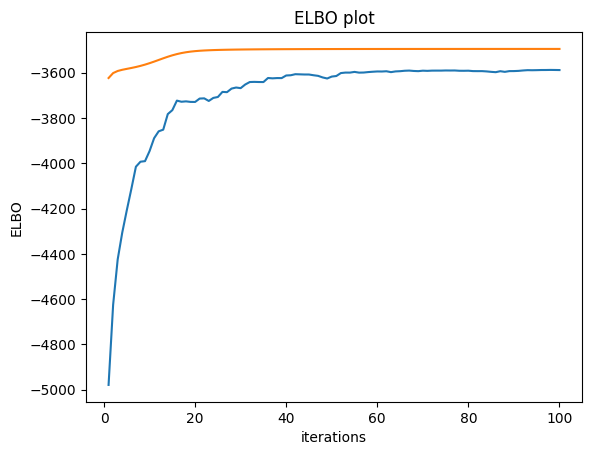

In [277]:
plt.plot(list(range(1, n_iter_cavi1 + 1)), elbo1_svi[np.arange(0, n_iter_svi1, int(n_iter_svi1 / n_iter_cavi1))])
plt.plot(list(range(1, n_iter_cavi1 + 1)), elbo1_cavi)
plt.title("ELBO plot")
plt.xlabel("iterations")
plt.ylabel("ELBO")
plt.show()

In [29]:
# Add your own code for evaluation here (will not be graded)

### CASE 2
Small dataset

In [278]:
np.random.seed(0)

# Data simulation parameters
D2 = 1000
N2 = 50
K2 = 3
W2 = 10
eta_sim2 = np.ones(W2)
alpha_sim2 = np.ones(K2)

w2, z2, theta2, beta2 = generate_data(D2, N2, K2, W2, eta_sim2, alpha_sim2)

# Inference parameters
n_iter_cavi2 = 100
n_iter_svi2 = 100
eta_prior2 = np.ones(W2) * 1.
alpha_prior2 = np.ones(K2) * 1.
S2 = 100 # batch size

start_cavi2 = time.time()
phi_out2_cavi, gamma_out2_cavi, lmbda_out2_cavi, elbo2_cavi = CAVI_algorithm(w2, K2, n_iter_cavi2, eta_prior2, alpha_prior2)
end_cavi2 = time.time()

start_svi2 = time.time()
phi_out2_svi, gamma_out2_svi, lmbda_out2_svi, elbo2_svi = SVI_algorithm(w2, K2, S2, n_iter_svi2, eta_prior2, alpha_prior2)
end_svi2 = time.time()

final_phi2_cavi = phi_out2_cavi[-1]
final_gamma2_cavi = gamma_out2_cavi[-1]
final_lmbda2_cavi = lmbda_out2_cavi[-1]
final_phi2_svi = phi_out2_svi[-1]
final_gamma2_svi = gamma_out2_svi[-1]
final_lmbda2_svi = lmbda_out2_svi[-1]

number of iterations: 0, elbo: -138643.3336522629
number of iterations: 1, elbo: -135105.2977253703
number of iterations: 2, elbo: -132832.43214057828
number of iterations: 3, elbo: -131138.0866050961
number of iterations: 4, elbo: -129383.56012820333
number of iterations: 5, elbo: -127721.69986973495
number of iterations: 6, elbo: -126318.14507964326
number of iterations: 7, elbo: -125181.45439032058
number of iterations: 8, elbo: -123981.21398369592
number of iterations: 9, elbo: -122621.15094007835
number of iterations: 10, elbo: -121943.46065139658
number of iterations: 11, elbo: -121389.15252519246
number of iterations: 12, elbo: -121048.99933078983
number of iterations: 13, elbo: -120836.12945955983
number of iterations: 14, elbo: -119925.51675860102
number of iterations: 15, elbo: -119805.15852921476
number of iterations: 16, elbo: -119489.99617357398
number of iterations: 17, elbo: -119440.62765444972
number of iterations: 18, elbo: -119700.88289087503
number of iterations: 19,

#### Evaluation
Do not expect perfect results in terms expectations being identical to the "true" theta and beta.
Do not expect the ELBO plot of your SVI alg to be the same as the CAVI alg. However, it should increase and be in the same ball park as that of the CAVI alg.

In [283]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(f"----- Recall label switching - compare E[theta] and true theta and check for label switching -----")
print(f"E[theta] of doc 0 SVI:      {final_gamma2_svi[0] / np.sum(final_gamma2_svi[0], axis=0, keepdims=True)}")
print(f"E[theta] of doc 0 CAVI:     {final_gamma2_cavi[0] / np.sum(final_gamma2_cavi[0], axis=0, keepdims=True)}")
print(f"True theta of doc 0:        {theta2[0]}")

print(f"----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----")
print(f"E[beta] k=0:    {final_lmbda2_svi[0, :] / np.sum(final_lmbda2_svi[0, :], axis=-1, keepdims=True)}")
print(f"E[beta] k=1:    {final_lmbda2_svi[1, :] / np.sum(final_lmbda2_svi[1, :], axis=-1, keepdims=True)}")
print(f"E[beta] k=2:    {final_lmbda2_svi[2, :] / np.sum(final_lmbda2_svi[2, :], axis=-1, keepdims=True)}")
print(f"E[beta] k=0:    {final_lmbda2_cavi[0, :] / np.sum(final_lmbda2_cavi[0, :], axis=-1, keepdims=True)}")
print(f"E[beta] k=1:    {final_lmbda2_cavi[1, :] / np.sum(final_lmbda2_cavi[1, :], axis=-1, keepdims=True)}")
print(f"E[beta] k=2:    {final_lmbda2_cavi[2, :] / np.sum(final_lmbda2_cavi[2, :], axis=-1, keepdims=True)}")
print(f"True beta k=0:  {beta2[0, :]}")
print(f"True beta k=1:  {beta2[1, :]}")
print(f"True beta k=2:  {beta2[2, :]}")

print(f"Time SVI: {end_svi2 - start_svi2}")
print(f"Time CAVI: {end_cavi2 - start_cavi2}")

----- Recall label switching - compare E[theta] and true theta and check for label switching -----
E[theta] of doc 0 SVI:      [0.431 0.353 0.216]
E[theta] of doc 0 CAVI:     [0.584 0.216 0.201]
True theta of doc 0:        [0.073 0.817 0.111]
----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----
E[beta] k=0:    [0.043 0.015 0.045 0.031 0.086 0.094 0.415 0.142 0.003 0.125]
E[beta] k=1:    [0.211 0.033 0.067 0.000 0.000 0.353 0.147 0.072 0.000 0.118]
E[beta] k=2:    [0.399 0.099 0.000 0.105 0.000 0.008 0.021 0.114 0.198 0.056]
E[beta] k=0:    [0.168 0.052 0.004 0.000 0.066 0.230 0.431 0.002 0.001 0.047]
E[beta] k=1:    [0.138 0.056 0.113 0.142 0.000 0.131 0.083 0.327 0.002 0.007]
E[beta] k=2:    [0.364 0.038 0.002 0.002 0.012 0.081 0.010 0.019 0.217 0.255]
True beta k=0:  [0.271 0.049 0.010 0.025 0.029 0.147 0.114 0.064 0.129 0.161]
True beta k=1:  [0.213 0.046 0.032 0.012 0.047 0.175 0.318 0.045 0.026 0.086]
True beta k=2:  [0.182 0.052 0.073 0.101 0.004 0.12

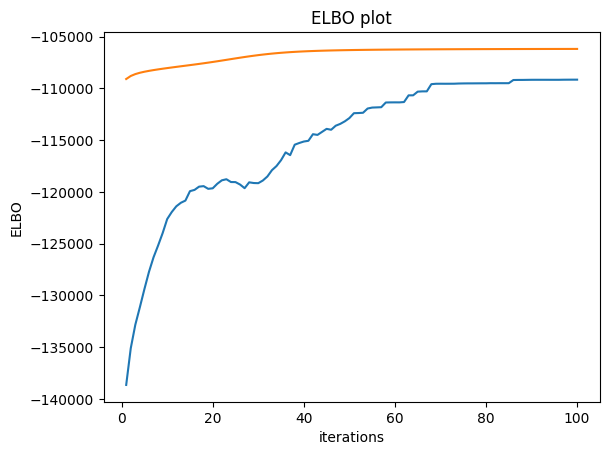

In [280]:
plt.plot(list(range(1, n_iter_cavi2 + 1)), elbo2_svi[np.arange(0, n_iter_svi2, int(n_iter_svi2 / n_iter_cavi2))])
plt.plot(list(range(1, n_iter_cavi2 + 1)), elbo2_cavi)
plt.title("ELBO plot")
plt.xlabel("iterations")
plt.ylabel("ELBO")
plt.show()

In [33]:
# Add your own code for evaluation here (will not be graded)

### CASE 3
Medium small dataset, one iteration for time analysis.

In [281]:
np.random.seed(0)

# Data simulation parameters
D3 = 10**4
N3 = 500
K3 = 5
W3 = 10
eta_sim3 = np.ones(W3)
alpha_sim3 = np.ones(K3)

w3, z3, theta3, beta3 = generate_data(D3, N3, K3, W3, eta_sim3, alpha_sim3)

# Inference parameters
n_iter3 = 1
eta_prior3 = np.ones(W3) * 1.
alpha_prior3 = np.ones(K3) * 1.
S3 = 100 # batch size

start_cavi3 = time.time()
phi_out3_cavi, gamma_out3_cavi, lmbda_out3_cavi, elbo3_cavi = CAVI_algorithm(w3, K3, n_iter3, eta_prior3, alpha_prior3)
end_cavi3 = time.time()

start_svi3 = time.time()
phi_out3_svi, gamma_out3_svi, lmbda_out3_svi, elbo3_svi = SVI_algorithm(w3, K3, S3, n_iter3, eta_prior3, alpha_prior3)
end_svi3 = time.time()

final_phi3_cavi = phi_out3_cavi[-1]
final_gamma3_cavi = gamma_out3_cavi[-1]
final_lmbda3_cavi = lmbda_out3_cavi[-1]
final_phi3_svi = phi_out3_svi[-1]
final_gamma3_svi = gamma_out3_svi[-1]
final_lmbda3_svi = lmbda_out3_svi[-1]

number of iterations: 0, elbo: -14825126.515121993


In [282]:
print(f"Examine per iteration run time.")
print(f"Time SVI: {end_svi3 - start_svi3}")
print(f"Time CAVI: {end_cavi3 - start_cavi3}")

Examine per iteration run time.
Time SVI: 6.704095840454102
Time CAVI: 124.4749870300293


In [36]:
# Add your own code for evaluation here (will not be graded)